In [2]:
import numpy as np
import pandas as pd
import cudaq
from cudaq import spin
from typing import List, Tuple
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(".."))
from Utils.qaoaCUDAQ import po_normalize, ret_cov_to_QUBO, qubo_to_ising, process_ansatz_values

import time

cudaq.set_target("nvidia")

In [3]:
# from qiskit_finance.applications.optimization import PortfolioOptimization
# from qiskit_optimization.algorithms import MinimumEigenOptimizer
# from qiskit_algorithms import QAOA
# from qiskit_algorithms.optimizers import COBYLA
# from qiskit.primitives import Sampler
# from qiskit_optimization.converters import QuadraticProgramToQubo
# from qiskit.circuit.library import QAOAAnsatz
# from qiskit_optimization.translators import to_ising
# from qiskit.result import marginal_distribution

# Preserving Mixer Hamiltonian

In [15]:
def pauli_to_int(pauli_str: str) -> int:
    value = 0
    for i, char in enumerate(pauli_str):
        if char == 'I':
            value |= (1 << (2 * i)) * 0
        elif char == 'X':
            value |= (1 << (2 * i)) * 1
        elif char == 'Y':
            value |= (1 << (2 * i)) * 2
        elif char == 'Z':
            value |= (1 << (2 * i)) * 3
    return value

def int_to_pauli(value: int, n_qubits: int) -> str:
    pauli_str = ""
    for i in range(n_qubits):
        if (value >> 2*i) % 4 == 0:
            pauli_str += 'I'
        elif (value >> 2*i) % 4 == 1:
            pauli_str += 'X'
        elif (value >> 2*i) % 4 == 2:
            pauli_str += 'Y'
        elif (value >> 2*i) % 4 == 3:
            pauli_str += 'Z'
    return pauli_str

def basis_T_to_pauli(bases: List[str], T: np.ndarray, n_qubits: int) -> Tuple[List[cudaq.pauli_word], List[float]]:
    def init_pauli(x, y):
        if x == "0" and y == "0":
            A = spin.i(0) + spin.z(0)
            B = 0
        elif x == "0" and y == "1":
            A = spin.x(0)
            B = -spin.y(0)
        elif x == "1" and y == "0":
            A = spin.x(0)
            B = spin.y(0)
        elif x == "1" and y == "1":
            A = spin.i(0) - spin.z(0)
            B = 0
        return A, B

    def transform_pauli(x, y, idx, A, B):
        if x == "0" and y == "0":
            A_, B_ = 0.5 * A * (spin.i(idx) + spin.z(idx)), 0
        elif x == "0" and y == "1":
            A_, B_ = 0.5 * (A * spin.x(idx) + B * spin.y(idx)), 0.5 * (B * spin.x(idx) - A * spin.y(idx))
        elif x == "1" and y == "0":
            A_, B_ = 0.5 * (A * spin.x(idx) - B * spin.y(idx)), 0.5 * (B * spin.x(idx) + A * spin.y(idx))
        elif x == "1" and y == "1":
            A_, B_ = 0.5 * A * (spin.i(idx) - spin.z(idx)), 0
        return A_, B_
    
    def get_pauli(X, Y):
        A, B = init_pauli(X[0], Y[0])
        for i in range(1, len(X)):
            A, B = transform_pauli(X[i], Y[i], i, A, B)
        return A, B
        
    A_all, B_all = 0, 0
    for i in range(T.shape[0]):
        for j in range(i + 1, T.shape[1]):
            A_now, B_now = get_pauli(bases[i], bases[j])
            A_all += T[i, j] * A_now
            B_all += T[i, j] * B_now
    
    ret_s, ret_c = [], []

    for i in A_all:
        s = i.get_pauli_word(n_qubits)
        c = i.evaluate_coefficient()
        if len(s) > 0 and c.real != 0:
            # ret_s.append(pauli_to_int(s))
            ret_s.append(s)
            # print(s)
            ret_c.append(c.real)
    
    return ret_s, ret_c
            

!! warning: Representing Pauli words using INTEGER !!

In [42]:
print(4**30 // 10**18)

1


# HAMILTONIAN BY CUDAQ

### by random values

In [5]:
B = 100
ret = np.array([1.1, 1.2, 1.3])
cov = np.random.rand(3, 3)
cov += cov.T
print(cov)
P = np.array([100, 100, 100])
lamb = 0 # Budget Penalty
q = 0 # Volatility Weight

# P_b, ret_b, cov_b = po_normalize(B, P, ret, cov)
P_bb, ret_bb, cov_bb, n_qubit = po_normalize(B, P, ret, cov)

print("n_qubit:", n_qubit)

QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
H = qubo_to_ising(QU, lamb)

[[0.92475517 1.46355341 1.2627631 ]
 [1.46355341 1.28527973 1.0687134 ]
 [1.2627631  1.0687134  0.650103  ]]
n_max: [1 1 1]
ret_bb: [1.1 1.2 1.3]
n_qubit: 3


In [6]:
print("Hamiltonian:", H)
idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

print(idx_1)
print(coeff_1, end="\n\n")
print(idx_2_a)
print(idx_2_b)
print(coeff_2)

Hamiltonian: (-0.55+0i) * I0 + (0.55+0i) * Z0 + (0+0i) + (-0.6+0i) * I1 + (0.6+0i) * Z1 + (-0.65+0i) * I2 + (0.65+0i) * Z2
[0, 1, 2]
[0.55, 0.6, 0.65]

[]
[]
[]


### by stock values

In [7]:
# data_cov = pd.read_csv("../dataset/top_50_us_stocks_data_20250526_011226_covariance.csv")
# data_ret_p = pd.read_csv("../dataset/top_50_us_stocks_returns_price.csv")

# nn = 3
# # B = 1500
# B = 270
# lamb = 3 # Budget Penalty
# q = 0 # Volatility Weight

# data_cov = data_cov.drop("Ticker", axis=1).iloc[:nn, :nn]
# print(data_cov)
# data_ret_p = data_ret_p.iloc[:nn]
# stock_names = data_ret_p["Ticker"].tolist()
# data_ret_p = data_ret_p.drop("Ticker", axis=1)

# data_cov = data_cov.to_numpy()
# data_ret_p = data_ret_p.to_numpy()

# data_ret = data_ret_p[:, 0]
# data_p = data_ret_p[:, 1]

# print(data_cov.shape)
# print(data_ret.round(5))
# print(data_p.round(2))
# print(stock_names)

In [8]:
# P_bb, ret_bb, cov_bb, n_qubit = po_normalize(B, data_p, data_ret, data_cov)

# print("n_qubit:", n_qubit)

# QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
# H = qubo_to_ising(QU, lamb)

In [9]:
# idx_1, coeff_1, idx_2_a, idx_2_b, coeff_2 = process_ansatz_values(H)

# QISKIT QAOA

In [10]:
# # cov[0, 2] = cov[2, 0] = 1
# print(cov)
# portfolio_qis = PortfolioOptimization(
#     expected_returns=ret,
#     covariances=cov,
#     risk_factor=0,
#     budget=1,
#     bounds=[(0, 1), (0, 1), (0, 1)]
# )
# qp = portfolio_qis.to_quadratic_program()
# converter = QuadraticProgramToQubo()
# qubo = converter.convert(qp)
# op, offset = to_ising(qubo)

In [11]:
# opp = op.to_sparse_list()
# print(opp)
# idx_1_qis = []
# coeff_1_qis = []
# idx_2_a_qis, idx_2_b_qis = [], []
# coeff_2_qis = []

# for i in range(len(opp)):
#     if len(opp[i][1]) == 1:
#         idx_1_qis.append(opp[i][1][0])
#         coeff_1_qis.append(opp[i][2].real)
#     elif len(opp[i][1]) == 2:
#         idx_2_a_qis.append(opp[i][1][0])
#         idx_2_b_qis.append(opp[i][1][1])
#         coeff_2_qis.append(opp[i][2].real)

# print(idx_1_qis)
# print(coeff_1_qis, end="\n\n")
# print(idx_2_a_qis)
# print(idx_2_b_qis)
# print(coeff_2_qis)

In [12]:
# qaoa_ansatz = QAOAAnsatz(op, reps=2)
# decomposed = qaoa_ansatz.decompose(reps=2)
# decomposed.draw(output='text')

In [13]:
# qaoa = QAOA(
#     optimizer=COBYLA(maxiter=1000),
#     reps=2,
#     sampler=Sampler()
# )

# meo = MinimumEigenOptimizer(qaoa)

# # result = meo.solve(qubo)

In [14]:
# qaoa_result = qaoa.compute_minimum_eigenvalue(operator=op)
# print("Optimized parameters:", qaoa_result.optimal_point)

In [15]:
# counts = qaoa_result.eigenstate
# counts = np.array(list(counts.values()))

In [16]:
# plt.figure(figsize=(10, 5))
# # plt.bar(range(2**qubit_count), list(result.values()))
# plt.bar(range(2**op.num_qubits), counts)
# # plt.xlabel('Cut')
# plt.ylabel('Frequency')
# plt.title('Distribution')
# # plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
# plt.xticks(visible=False)
# plt.show()

# CUDA QAOA

In [24]:
@cudaq.kernel
def kernel_qaoa_ham(qubit_count: int, layer_count: int, thetas: List[float], idx_1: List[int], coeff_1: List[float], idx_2_a: List[int], idx_2_b: List[int], coeff_2: List[float], mixer_str: List[cudaq.pauli_word], mixer_coeff: List[float]):
    qreg = cudaq.qvector(qubit_count)
    h(qreg)
    
    for i in range(layer_count):

        for j in range(len(idx_1)):
            rz(2 * coeff_1[j] * thetas[i], qreg[idx_1[j]])
        
        for j in range(len(idx_2_a)):
            x.ctrl(qreg[idx_2_a[j]], qreg[idx_2_b[j]])
            rz(2 * coeff_2[j] * thetas[i], qreg[idx_2_b[j]])
            x.ctrl(qreg[idx_2_a[j]], qreg[idx_2_b[j]])

        # exp_pauli(0.5, qreg, "XXI")
        for j in range(len(mixer_str)):
            exp_pauli(mixer_coeff[j] * thetas[layer_count + i], qreg, mixer_str[j])

        # for j in range(qubit_count):
        #     rx(2.0 * thetas[layer_count + i], qreg[j])


In [8]:
idx_1_use, coeff_1_use = idx_1, coeff_1
idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a, idx_2_b, coeff_2

# idx_1_use, coeff_1_use = idx_1_qis, coeff_1_qis
# idx_2_a_use, idx_2_b_use, coeff_2_use = idx_2_a_qis, idx_2_b_qis, coeff_2_qis

In [9]:
print(H)
print(n_qubit)

(-0.55+0i) * I0 + (0.55+0i) * Z0 + (0+0i) + (-0.6+0i) * I1 + (0.6+0i) * Z1 + (-0.65+0i) * I2 + (0.65+0i) * Z2
3


In [32]:
bases = ["010", "110"]
T = np.array([[0, 1], [1, 0]])

mixer_s, mixer_c = basis_T_to_pauli(bases, T, n_qubit)

# ss_i = [int_to_pauli(s, n_qubit) for s in mixer_s]
# print(f"{mixer_s}\n{ss_i}\n{mixer_c}")

print(f"{mixer_s}\n{mixer_c}")

['XII', 'XIZ', 'XZI', 'XZZ']
[0.25, 0.25, -0.25, -0.25]


In [50]:
print(cudaq.draw(kernel_qaoa_ham, n_qubit, 1, [1]*4, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c)) 

     ╭───╮╭─────────╮╭───╮╭──────────╮╭───╮╭───╮                      ╭───╮»
q0 : ┤ h ├┤ rz(1.1) ├┤ h ├┤ rz(-0.5) ├┤ h ├┤ h ├──●────────────────●──┤ h ├»
     ├───┤├─────────┤╰───╯╰──────────╯╰───╯╰───╯  │                │  ╰───╯»
q1 : ┤ h ├┤ rz(1.2) ├─────────────────────────────┼────────────────┼───────»
     ├───┤├─────────┤                           ╭─┴─╮╭──────────╮╭─┴─╮     »
q2 : ┤ h ├┤ rz(1.3) ├───────────────────────────┤ x ├┤ rz(-0.5) ├┤ x ├─────»
     ╰───╯╰─────────╯                           ╰───╯╰──────────╯╰───╯     »

################################################################################

╭───╮                     ╭───╮╭───╮                               ╭───╮
┤ h ├──●───────────────●──┤ h ├┤ h ├──●─────────────────────────●──┤ h ├
╰───╯╭─┴─╮╭─────────╮╭─┴─╮╰───╯╰───╯╭─┴─╮                     ╭─┴─╮╰───╯
─────┤ x ├┤ rz(0.5) ├┤ x ├──────────┤ x ├──●───────────────●──┤ x ├─────
     ╰───╯╰─────────╯╰───╯          ╰───╯╭─┴─╮╭─────────╮╭─┴─╮╰───╯     
─────────────

# Ansatz Architecture

In [35]:
idx = 3
layer_count = 5

parameter_count = layer_count * 2

optimizer1 = cudaq.optimizers.NelderMead()
optimizer2 = cudaq.optimizers.COBYLA()
optimizer3 = cudaq.optimizers.SPSA()
optimizer4 = cudaq.optimizers.Adam()
optimizer5 = cudaq.optimizers.GradientDescent()

optimizer = [optimizer1, optimizer2, optimizer3, optimizer4, optimizer5][idx]
optimizer_names = ["Nelder-Mead", "COBYLA", "SPSA", "Adam", "GradientDescent"]
optimizer_name = optimizer_names[idx]
FIND_GRAD = True if optimizer.requires_gradients() else False

optimizer.max_iterations = 1000

optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)

Initial parameters =  [-0.04343870720809517, 0.10049866188576562, -0.35446365788351264, -0.2853750805551498, 0.3810068872079676, -0.13079129838491743, -0.12830930937056523, -0.11360969840173202, 0.08098132719564577, -0.2452873829455036]


# Optimize

In [36]:
expectations = []

def cost_func(parameters):
    # return cudaq.observe(kernel_qaoa, H, n_qubit, layer_count, parameters, 0).expectation()
    return cudaq.observe(kernel_qaoa_ham, H, n_qubit, layer_count, parameters, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c).expectation()

def objective(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)
    return expectation

def objective_grad_cuda(parameters):
    expectation = cost_func(parameters)
    expectations.append(expectation)

    gradient = cudaq.gradients.ForwardDifference().compute(parameters, cost_func, expectation)

    return expectation, gradient

objective_func = objective_grad_cuda if FIND_GRAD else objective
print("Required Gradient = ", FIND_GRAD)

Required Gradient =  True


In [37]:
st = time.time()
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective_func)
et = time.time()

if not os.path.exists("./output_PO_mixer"):
    os.makedirs("./output_PO_mixer")
np.save(f"./output_PO_mixer/expectations_{optimizer_name}.npy", np.array(expectations))

print('optimal_expectation =', optimal_expectation)
print('optimal_parameters =', optimal_parameters)
print('Time taken = ', et - st)

optimal_expectation = -1.9371935619274152
optimal_parameters = [-0.2901925412328878, -0.1597828448803625, -0.6223251228468862, -0.5627796948802795, 0.11331042835539555, -0.13842902897082468, 0.11670198431614953, -0.27805045130624406, -0.1263101106009334, -0.44009690703053805]
Time taken =  1.8487014770507812


In [39]:
shots_count = int(1e6)
print(f"Sampling {shots_count} times...")
# result = cudaq.sample(kernel_qaoa, int(n_qubit), layer_count, optimal_parameters, 0, shots_count=shots_count)
result = cudaq.sample(kernel_qaoa_ham, int(n_qubit), layer_count, optimal_parameters, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c, shots_count=shots_count)

print("Finding the best solution...")
idx_b2 = result.most_probable()
idx = int(idx_b2, 2)
idx_r = 2**n_qubit - 1 - int(idx_b2, 2)
idx_r_b2 = bin(idx_r)[2:].zfill(n_qubit)

print(idx_b2, result[idx_b2], result[idx_b2]/shots_count)
# print(idx_r_b2, result[idx_r_b2], result[idx_r_b2]/shots_count)
print("|q0>|q1>|q2>...")



Sampling 1000000 times...
Finding the best solution...
110 248945 0.248945
|q0>|q1>|q2>...


In [49]:
state = cudaq.get_state(kernel_qaoa_ham, int(n_qubit), layer_count, optimal_parameters, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c)
print(state)

for i in range(len(state)):
    print(abs(state[i]))

print(len(state))

SV: [(-0.325312,0.138464), (0.171224,0.309326), (-0.0176471,0.00314041), (0.329512,-0.375634), (0.256053,0.243797), (0.216136,-0.279795), (0.171224,-0.309326), (-0.325312,-0.138464)]

0.3535534697466077
0.3535534953378168
0.017924386636320285
0.3535535321237938
0.3535534366760434
0.3535533741918828
0.4996786622678383
0.3535534032315133
8


In [ ]:
assert False

AssertionError: 

In [40]:
result_final = np.zeros(2**n_qubit)
for i in result:
    result_final[int(i, 2)] = result[i]

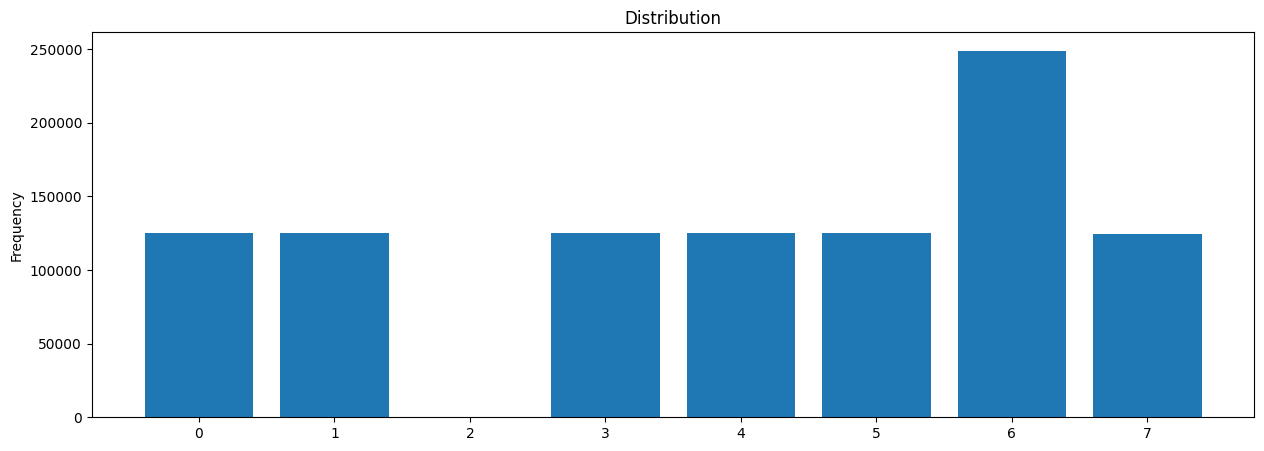

In [41]:
# plt.figure(figsize=(100, 15))
plt.figure(figsize=(15, 5))
# plt.bar(range(2**qubit_count), list(result.values()))
plt.bar(range(2**n_qubit), result_final)
# plt.bar(range(int(2**(n_qubit-3)*0.1)), result_final[2**(n_qubit-3)*4:int(2**(n_qubit-3)*4.1)])
plt.ylabel('Frequency')
plt.title('Distribution')
# plt.gca().set_xticklabels([])
# plt.xticks(rotation=90)
# plt.xticks(visible=False)
plt.show()

Expectations file not found for Nelder-Mead
Expectations file not found for COBYLA
Expectations file not found for SPSA
Loading expectations from Adam
Expectations file not found for GradientDescent


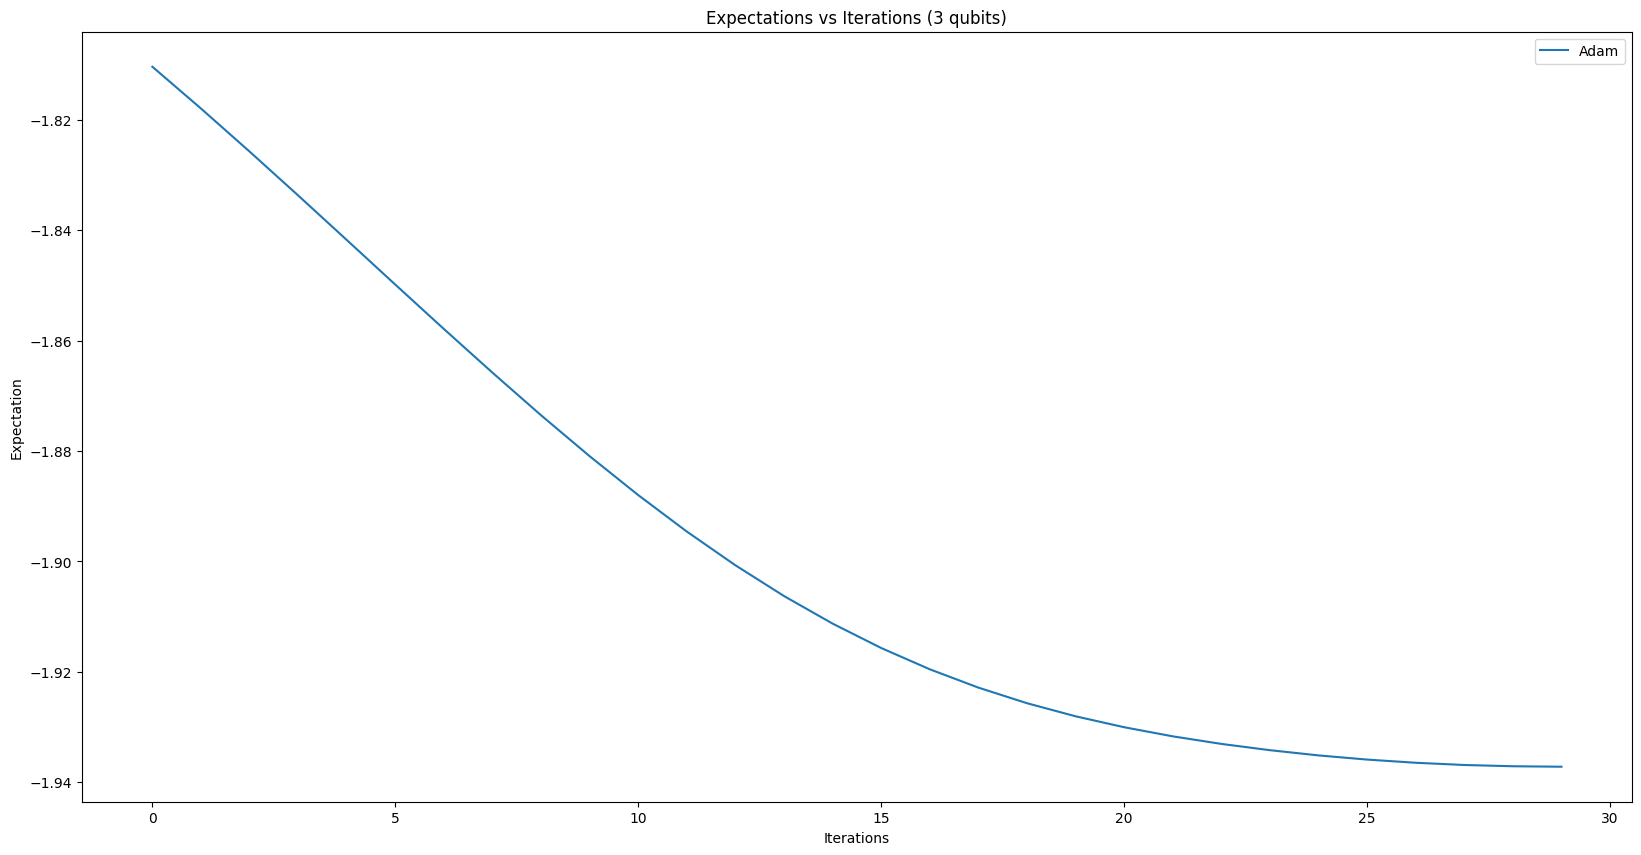

In [42]:
plt.figure(figsize=(20, 10))
for i in range(len(optimizer_names)):
    if os.path.exists(f"./output_PO_mixer/expectations_{optimizer_names[i]}.npy"):
        print(f"Loading expectations from {optimizer_names[i]}")
    else:
        print(f"Expectations file not found for {optimizer_names[i]}")
        continue
    expectations = np.load(f"./output_PO_mixer/expectations_{optimizer_names[i]}.npy")
    plt.plot(expectations, label=optimizer_names[i])
plt.xlabel('Iterations')
plt.ylabel('Expectation')
plt.title(f'Expectations vs Iterations ({n_qubit} qubits)')
plt.legend()
plt.show()